In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import special_ortho_group
import seaborn as sns
import pandas as pd

# Goal 
To generate data (6 distinct groups) with trajectory in time

data_structure = [[n_1 data], [n_2 data]]

In [101]:
# c = number of class
# t = timepoints
# d = dimention of data
# a = amplitude

c = 2
t = 1000
d = 2
to_d = 10
a = 1

In [102]:
theta = np.linspace(0, 2*np.pi, c+1)
theta = theta[:-1]
theta


array([0.        , 3.14159265])

In [103]:
def find_coords(theta, class_num):
    x = a * np.cos(theta[class_num])
    y = a * np.sin(theta[class_num])
    return [x, y]

def transformation_to_n_dim(data, from_d, to_d):
    new_data = np.zeros((data.shape[0], to_d, data.shape[2]))

    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            # print(data[i, :, j].shape)
            new_data[i, :, j] = np.hstack((data[i, :, j], np.zeros(to_d - from_d)))
    
    return new_data

random_rotation_matrix = special_ortho_group.rvs(to_d, random_state=42)

def rotation(data, seed = 42, d = to_d, random_rotation_matrix = random_rotation_matrix):
    random_rotated = np.zeros((data.shape[0], to_d, data.shape[2]))
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            random_rotated[i, :, j] = np.matmul(data[i, :, j], random_rotation_matrix)

    return random_rotated

In [104]:
data = np.zeros((c, d, t))

In [105]:
# Initial location
for i in range(c):
    data[i, :, 0] = find_coords(theta, i)
    print(find_coords(theta, i))    

[np.float64(1.0), np.float64(0.0)]
[np.float64(-1.0), np.float64(1.2246467991473532e-16)]


In [106]:
def rotation_matrix(matrix, degree):
    deg = np.radians(degree)
    rotation_operation = np.array([[np.cos(deg), -np.sin(deg)], [np.sin(deg), np.cos(deg)]])
    product = rotation_operation @ matrix
    return product

def generate_data(c, t, d, to_d, a, theta):
    data = np.zeros((c, d, t))

    # Initial location
    for i in range(c):
        data[i, :, 0] = find_coords(theta, i)
        # print(find_coords(theta, i))

    for i in range(t):
        if i == 0:
            continue
        for j in range(c):
            data[j, :, i] = rotation_matrix(
                data[j, :, i - 1], 1
            ) * 1.001 + np.random.normal(0, 0.01, (1, d))

    data = transformation_to_n_dim(data, d, to_d)

    rotated = rotation(data)

    return rotated

In [107]:
from sklearn.decomposition import PCA
data_train = []
data_test = []

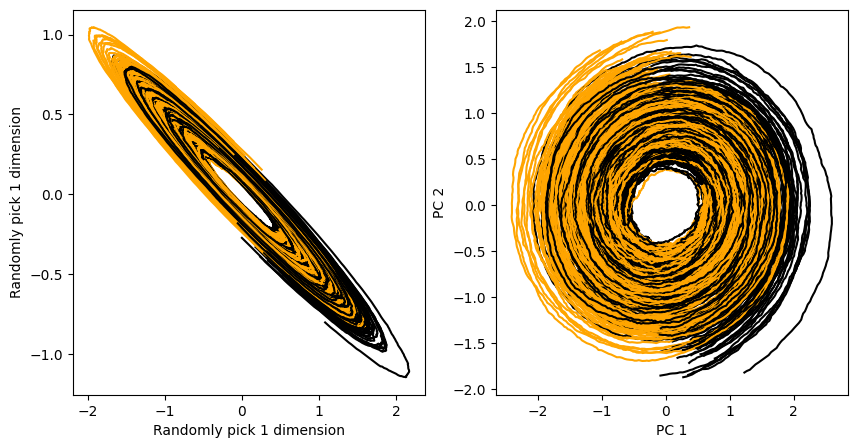

(2, 10, 100)
(2, 2, 100)


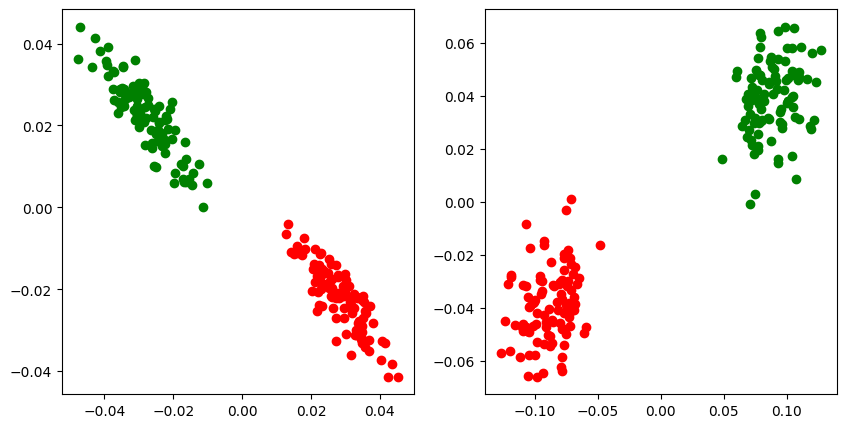

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

n = 100

average = np.zeros((c, to_d, n))
average_PCA = np.zeros((c, d, n))


def generate_to_plot_PCA(n):
    for j in range(n):
        gen_data = generate_data(c, t, d, to_d, a, theta)

        color = ["orange", "black", "green", "blue", "red", "purple"]
        pca = PCA(n_components=2)
        
        all_data = np.hstack(
            (
                gen_data[0, :5, :],
                gen_data[1, :5, :],
            )
        )
        # print(all_data.shape)

        for i in range(c):
            recovered_data = pca.fit_transform(all_data.T).T
            # print(recovered_data.shape)
            ax[0].plot(gen_data[i, 4, :], gen_data[i, 5, :], color=color[i])
            ax[0].set_xlabel("Randomly pick 1 dimension")
            ax[0].set_ylabel("Randomly pick 1 dimension")

        for i in range(c):
            epoch_data = gen_data.shape[2]

            ax[1].plot(
                recovered_data[0, i * epoch_data : (i + 1) * (epoch_data)],
                recovered_data[1, i * epoch_data : (i + 1) * (epoch_data)],
                color=color[i],
            )
            ax[1].set_xlabel("PC 1")
            ax[1].set_ylabel("PC 2")

        recovered_data_unstack = np.zeros((c, d, gen_data.shape[2]))

        for i in range(c):
            recovered_data_unstack[i, :, :] = recovered_data[
                :, i * epoch_data : (i + 1) * (epoch_data)
            ]

        # print (gen_data.shape)
        # print (recovered_data_unstack.shape)

        # get the average of each class (for 1000 timepoints)
        for i in range(c):
            average[i, :, j] = np.mean(gen_data[i, :, :], axis=1)
            average_PCA[i, :, j] = np.mean(recovered_data_unstack[i, :, :], axis=1)

        # for i in range(c):
        #     average[n, i, :] = np.mean(gen_data[i, :, :], axis = 1)
        #     average_PCA[n, i, :] = np.array([np.mean(recovered_data[0, :], axis = 1), np.mean(recovered_data[1, :], axis = 1)]).T

        # print(average.shape)
        # print(recovered_data_1.shape)
        # plt.scatter(average[:, 0], average[:, 1], color = color)

        # for i in range((recovered_data_1.shape[0])):
        #     data_train.append(recovered_data_1[i, :])
        #     data_test.append(i)


generate_to_plot_PCA(n)

plt.show()

print(average.shape)
print(average_PCA.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i in range(c):
    ax[0].scatter(average[i, 0, :], average[i, 1, :], color=color[i])
    ax[1].scatter(average_PCA[i, 0, :], average_PCA[i, 1, :], color=color[i])

In [109]:
print(average.shape)
print(average_PCA.shape)

(2, 10, 100)
(2, 2, 100)


[0 0 0 0 0]
Accuracy: (1.0, 1.0)


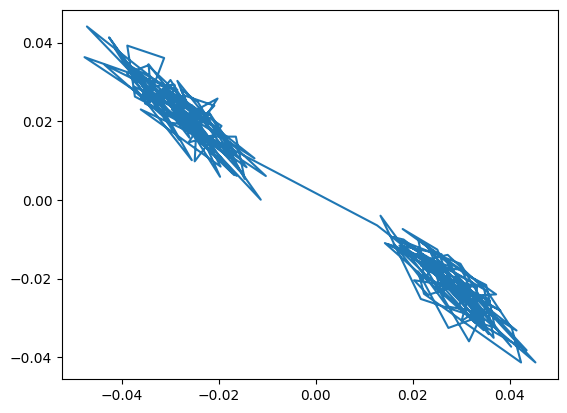

In [111]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# print(average.shape)
# print(average_PCA.shape)

average_stack = np.zeros((to_d, c*n))
average_stack = np.hstack((average[0, :2, :], average[1, :2, :])).T

average_PCA_stack = np.zeros((d, c*n))
average_PCA_stack = np.hstack((average_PCA[0, :, :], average_PCA[1, :, :])).T

answer = np.array([0]*n + [1]*n)
answer_pca = np.array([0]*n + [1]*n)

plt.plot(average_stack[:, 0], average_stack[:, 1])
print(answer[:5])

average_stack_train, average_stack_test, answer_train, answer_test = train_test_split(
    average_stack, answer, test_size=0.2, random_state=42, shuffle=True)

average_PCA_stack_train, average_PCA_stack_test, answer_pca_train, answer_pca_test = train_test_split(
    average_PCA_stack, answer_pca, test_size=0.2, random_state=42, shuffle=True)

# Initialize and train the SVM classifier
clf = svm.SVC()
clf_pca = svm.SVC()

clf.fit(average_stack_train, answer_train)
clf_pca.fit(average_PCA_stack_train, answer_pca_train)

# Now you can use clf to make predictions on the test set
predictions = clf.predict(average_stack_test)
predictions_pca = clf_pca.predict(average_PCA_stack_test)

accuracy = accuracy_score(answer_test, predictions)
accuracy_pca = accuracy_score(answer_pca_test, predictions_pca)

print(f"Accuracy: {accuracy, accuracy_pca}")

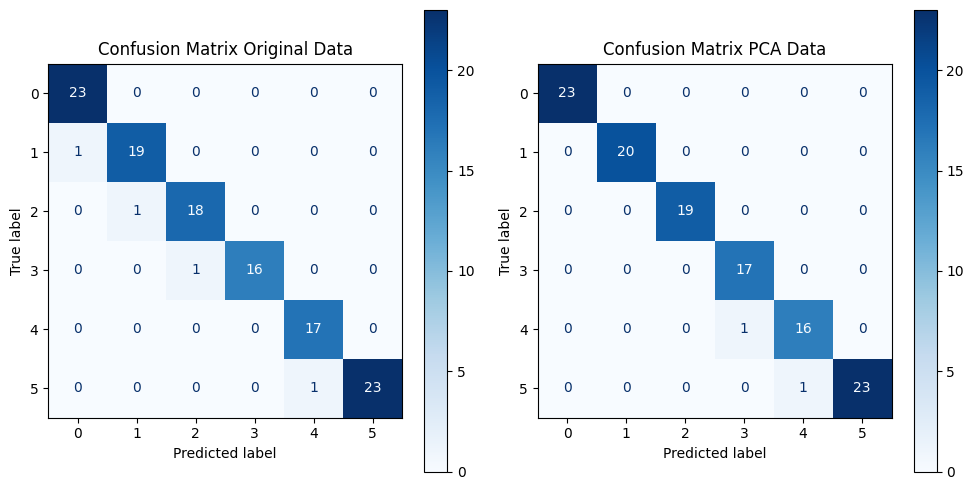

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot confusion matrix for original data
cm = confusion_matrix(answer_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title('Confusion Matrix Original Data')

# Assuming predictions_pca and clf_pca are defined similarly for the PCA data
cm_pca = confusion_matrix(answer_test, predictions_pca, labels=clf_pca.classes_)
disp_pca = ConfusionMatrixDisplay(confusion_matrix=cm_pca, display_labels=clf_pca.classes_)
disp_pca.plot(cmap=plt.cm.Blues, ax=ax[1])
ax[1].set_title('Confusion Matrix PCA Data')

plt.tight_layout()
plt.show()

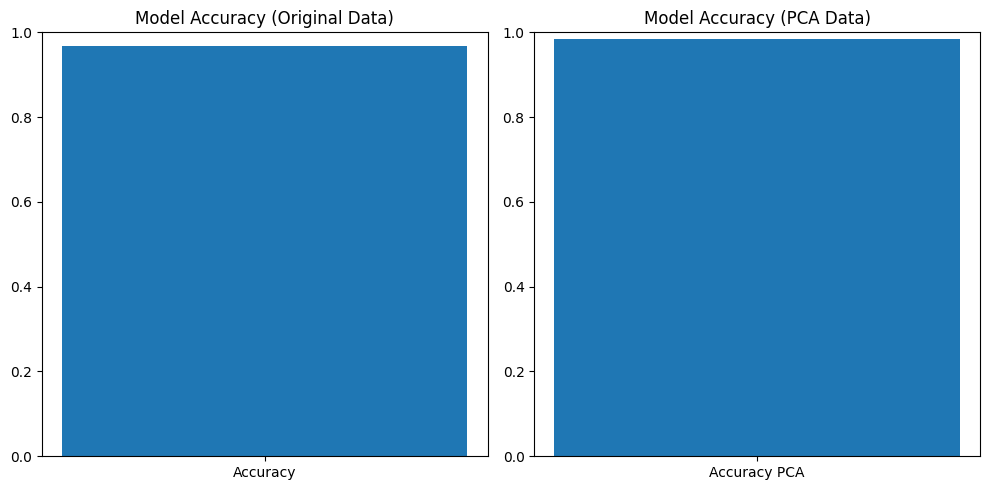

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Assuming accuracy and accuracy_pca are defined
# Plot accuracy for the original model
ax[0].bar(['Accuracy'], [accuracy])
ax[0].set_ylim(0, 1)
ax[0].set_title('Model Accuracy (Original Data)')

# Plot accuracy for the PCA model
ax[1].bar(['Accuracy PCA'], [accuracy_pca])
ax[1].set_ylim(0, 1)
ax[1].set_title('Model Accuracy (PCA Data)')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)
(5, 6000)


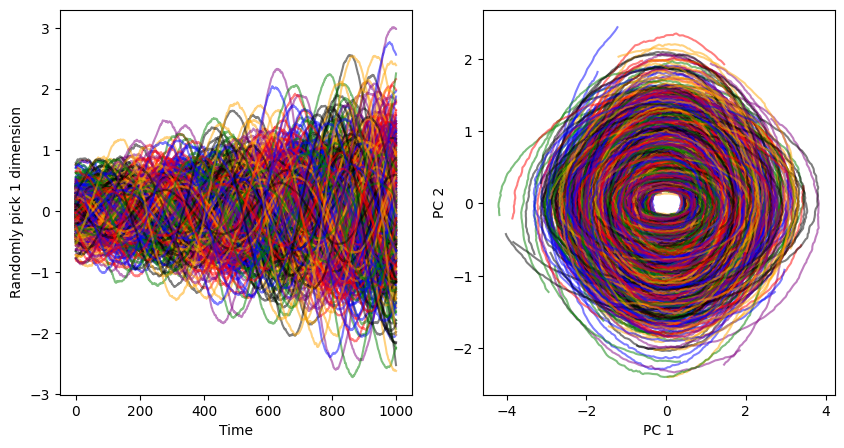

In [ ]:
np.random.seed(42)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
def generate_to_plot_Perceptron():
    gen_data = generate_data(c, t, d, to_d, a, theta)

    # random_mat = np.random.rand(10, 10)
    random_mat = np.random.uniform(0, 1, (to_d, to_d))
    # random_mat = np.identity(to_d)
    
    for i in range(gen_data.shape[0]):
        gen_data[i, :, :] = random_mat @ gen_data[i, :, :]


    average = np.zeros((c, to_d))

    color = ['orange', 'black', 'green', 'blue', 'red', 'purple']
    pca = PCA(n_components=5)


    all_data = np.hstack((gen_data[0, :5, :], gen_data[1, :5, :], gen_data[2, :5, :], gen_data[3, :5, :], gen_data[4, :5, :], gen_data[5, :5, :]))
    print(all_data.shape)

    for i in range(c):
        recovered_data = pca.fit_transform(all_data.T).T
        print(recovered_data.shape)
        ax[0].plot(np.arange(1000),gen_data[i, 0, :], color = color[i], alpha = 0.5)
        ax[0].set_xlabel('Time')
        ax[0].set_ylabel('Randomly pick 1 dimension')

    for i in range(c):
        epoch_data = gen_data.shape[2]

        ax[1].plot(recovered_data[0, i*epoch_data:(i+1)*(epoch_data)], recovered_data[1, i*epoch_data:(i+1)*(epoch_data)], color = color[i], alpha = 0.5)
        ax[1].set_xlabel('PC 1')
        ax[1].set_ylabel('PC 2')

    for i in range(c):
        average[i, :] = np.mean(gen_data[i, :, :], axis = 1)
        
    # print(average.shape)
    pca = PCA(n_components=2)
    recovered_data_1 = pca.fit_transform(average)

    # print(recovered_data_1.shape)


    
    # plt.scatter(average[:, 0], average[:, 1], color = color)

    for i in range((recovered_data_1.shape[0])):
        data_train.append(recovered_data_1[i, :])
        data_test.append(i)


    

for i in range(100):
    generate_to_plot_Perceptron()

plt.show()
 